<a id='home'></a>
### Содержание

[Импорты](#Импорты)

[Загрузка данных](#Загрузкаданных)

[Лемматизация](#Лемматизация)

[Tf-Idf Преобразование](#Tf-IdfПреобразование)

[Fasttext](#Fasttext)

[RuBert](#RuBert)

<a id='Импорты'></a>
### Импорты
[к содержанию](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q gensim==4.2.0
!pip install -q pymystem3==0.2.0
!pip install -q pymorphy2==0.9.1
# !python3 -m pip install bulk

     |███▍                            | 2.5 MB 5.2 MB/s eta 0:00:05

     |██████████▎                     | 7.7 MB 5.2 MB/s eta 0:00:04

     |███████████████▋                | 11.8 MB 5.2 MB/s eta 0:00:03

     |████████████████████▏           | 15.2 MB 5.2 MB/s eta 0:00:02

     |████████████████████████▌       | 18.4 MB 5.2 MB/s eta 0:00:02

     |████████████████████████████▋   | 21.5 MB 1.4 MB/s eta 0:00:02

     |████████████████████████████████| 24.1 MB 1.4 MB/s eta 0:00:01

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
     |████████████████████████████████| 55 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 9.9 MB/s eta 0:00:01


In [3]:
import gc
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections
import requests 
from urllib.parse import urlencode 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [26]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
def get_csv_from_yandex_disk(url: str, **kwargs) -> pd.DataFrame:
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = url

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url) 
    df = pd.read_csv(download_url, **kwargs) 
    return df

---

<a id='Загрузкаданных'></a>
### Загрузка данных
[к содержанию](#home)

In [6]:
%%time
df = get_csv_from_yandex_disk(url='https://disk.yandex.ru/d/ixl8nC-cntmqOQ', nrows=300_000)
print(f"{df.shape[0]:,} x {df.shape[1]:,}")
df.head()

300,000 x 4
CPU times: user 17.8 s, sys: 10.7 s, total: 28.4 s
Wall time: 4min 17s


,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df.sample(n=min(1_000_000, df.shape[0]), random_state=42), 
    test_size=0.3, 
    random_state=42
)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(f"train: {train_df.shape[0]:,}")
print(f"test: {test_df.shape[0]:,}")

train: 210,000
test: 90,000


In [20]:
category_id, category_name = train_df[['Category', 'Category_name']].drop_duplicates().T.values
categories_mapping = dict(zip(category_id, category_name))

In [8]:
del df
gc.collect()

24

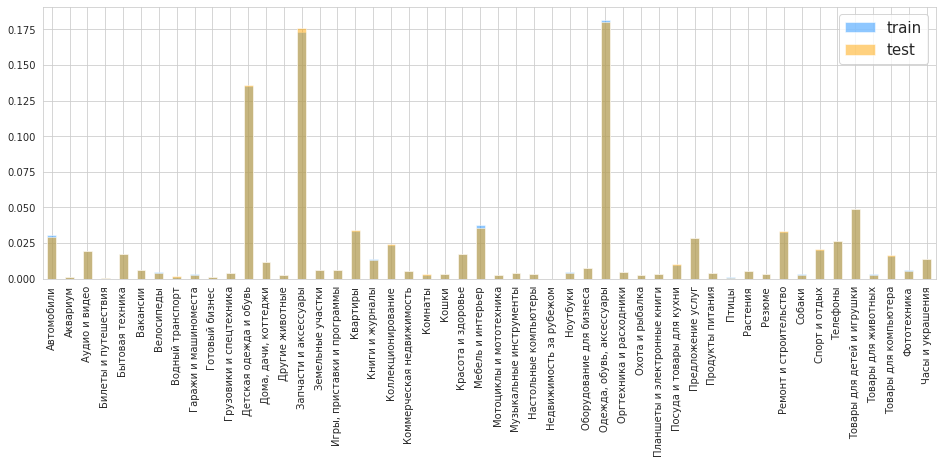

In [9]:
train_df['Category_name'].value_counts(1).sort_index().plot(
    kind='bar', figsize=(16, 5), color='dodgerblue', alpha=0.5, label='train'
);
test_df['Category_name'].value_counts(1).sort_index().plot(
    kind='bar', figsize=(16, 5), color='orange', alpha=0.5, label='test'
);
plt.legend(fontsize=15);

<a id='Лемматизация'></a>
### Лемматизация
[к содержанию](#home)

In [11]:
import re
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer

In [12]:
morph = MorphAnalyzer()
train_lemmatized_descriptions = []
for i, description in tqdm(enumerate(train_df['description'].values), total=len(train_df)):
    try:
        lemmatized_description = [
            morph.parse(token)[0].normal_form for token in 
            re.findall(r'\w+', description)
        ]
        train_lemmatized_descriptions.append(lemmatized_description)
    except Exception as e:
        print(f'Не удалось распарсить description с индексом={i}:')
        print("descrition:")
        print(description, end='\n\n')
        print(e, end='\n\n')
        train_lemmatized_descriptions.append([])
train_df['lemmatized_descriptions'] = train_lemmatized_descriptions
try:
    json.dump(
        train_lemmatized_descriptions, 
        open('/content/drive/MyDrive/Data/avito_train_lemmatized_210k.json', mode='w', encoding='utf-8'), 
        ensure_ascii=False, 
        indent=2
    )
except Exception as e:
    print("Не удалось сохранить в /content/drive/MyDrive/Data/avito_train_lemmatized_210k.json")
    print(e, end='\n\n')

test_lemmatized_descriptions = []
for i, description in tqdm(enumerate(test_df['description'].values), total=len(test_df)):
    try:
        lemmatized_description = [
            morph.parse(token)[0].normal_form for token in 
            re.findall(r'\w+', description)
        ]
        test_lemmatized_descriptions.append(lemmatized_description)
    except Exception as e:
        print(f'Не удалось распарсить description с индексом={i}:')
        print("descrition:")
        print(description, end='\n\n')
        print(e, end='\n\n')
        test_lemmatized_descriptions.append([])
    
test_df['lemmatized_descriptions'] = test_lemmatized_descriptions
try:
    json.dump(
        test_lemmatized_descriptions, 
        open('/content/drive/MyDrive/Data/avito_test_lemmatized_90k.json', mode='w', encoding='utf-8'), 
        ensure_ascii=False, 
        indent=2
    )
except Exception as e:
    print("Не удалось сохранить в /content/drive/MyDrive/Data/avito_test_lemmatized_90k.json")
    print(e, end='\n\n')

  0%|          | 0/210000 [00:00<?, ?it/s]

  0%|          | 0/90000 [00:00<?, ?it/s]

In [13]:
train_lemmatized_descriptions = json.load(
#     open('/content/drive/MyDrive/Data/avito_train_lemmatized.json', mode='r', encoding='utf-8'), 
    open('/content/drive/MyDrive/Data/avito_train_lemmatized_210k.json', mode='r', encoding='utf-8'), 
)
test_lemmatized_descriptions = json.load(
#     open('/content/drive/MyDrive/Data/avito_test_lemmatized.json', mode='r', encoding='utf-8'),
    open('/content/drive/MyDrive/Data/avito_test_lemmatized_90k.json', mode='r', encoding='utf-8'),
)

print(f"train_lemmatized_descriptions: {len(train_lemmatized_descriptions):,}")
print(f"test_lemmatized_descriptions: {len(test_lemmatized_descriptions):,}")

train_lemmatized_descriptions: 210,000
test_lemmatized_descriptions: 90,000


<a id='Tf-IdfПреобразование'></a>
### Tf-Idf Преобразование
[к содержанию](#home)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
russian_stop_words = list(
    pd.read_csv('https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt', header=None)[0]
)
print(len(russian_stop_words))
print(np.random.choice(russian_stop_words, size=15))

559
['всеми' 'седьмой' 'понять' 'по' 'может быть' 'никакой' 'ему' 'само'
 'никогда' 'ваши' 'иметь' 'значить' 'советский' 'дело' 'г']


In [16]:
%%time
tf_idf = TfidfVectorizer(
    stop_words=russian_stop_words,
    min_df=4,
    max_df=0.97,
    max_features=10_000,
    ngram_range=(1, 2),
)

tf_idf.fit([' '.join(str(word).lower() for word in sentence) for sentence in train_lemmatized_descriptions])
X_tr = tf_idf.transform(
    [' '.join(str(word).lower() for word in sentence) for sentence in train_lemmatized_descriptions]
)
X_te = tf_idf.transform(
    [' '.join(str(word).lower() for word in sentence) for sentence in test_lemmatized_descriptions]
)
print(f"X_tr: {X_tr.shape[0]:,} x {X_tr.shape[1]:,}")
print(f"X_te: {X_te.shape[0]:,} x {X_te.shape[1]:,}")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['хотел'] not in stop_words.
  % sorted(inconsistent)


X_tr: 210,000 x 10,000
X_te: 90,000 x 10,000
CPU times: user 1min 8s, sys: 2.18 s, total: 1min 10s
Wall time: 1min 11s


In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
%%time
lr = LogisticRegression(C=1.0, random_state=42)
lr.fit(X_tr, train_df['Category'].values)

CPU times: user 2min 31s, sys: 27.7 s, total: 2min 59s
Wall time: 2min 30s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [18]:
category_id, category_name = train_df[['Category', 'Category_name']].drop_duplicates().T.values
categories_mapping = dict(zip(category_id, category_name))
categories_mapping

{27: 'Одежда, обувь, аксессуары',
 10: 'Запчасти и аксессуары',
 19: 'Ремонт и строительство',
 29: 'Детская одежда и обувь',
 84: 'Телефоны',
 9: 'Автомобили',
 34: 'Велосипеды',
 106: 'Растения',
 20: 'Мебель и интерьер',
 111: 'Вакансии',
 24: 'Квартиры',
 30: 'Товары для детей и игрушки',
 39: 'Спорт и отдых',
 28: 'Часы и украшения',
 40: 'Оборудование для бизнеса',
 94: 'Товары для животных',
 21: 'Бытовая техника',
 81: 'Грузовики и спецтехника',
 83: 'Книги и журналы',
 101: 'Товары для компьютера',
 88: 'Красота и здоровье',
 98: 'Ноутбуки',
 36: 'Коллекционирование',
 32: 'Аудио и видео',
 26: 'Земельные участки',
 97: 'Игры, приставки и программы',
 105: 'Фототехника',
 114: 'Предложение услуг',
 42: 'Коммерческая недвижимость',
 11: 'Водный транспорт',
 23: 'Комнаты',
 87: 'Посуда и товары для кухни',
 93: 'Другие животные',
 31: 'Настольные компьютеры',
 14: 'Мотоциклы и мототехника',
 25: 'Дома, дачи, коттеджи',
 82: 'Продукты питания',
 96: 'Планшеты и электронные книги'

In [20]:
from sklearn.metrics import classification_report

classification_report_df = pd.DataFrame(classification_report(
    y_true=test_df['Category'].values,
    y_pred=lr.predict(X_te),
    target_names=[val for key, val in sorted(categories_mapping.items(), key=lambda x: x[0])],
    sample_weight=None,
    digits=2,
    output_dict=True,
    zero_division="warn",
)).T
classification_report_df.style.background_gradient(axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Автомобили,0.873375,0.889225,0.881229,2645.000000
Запчасти и аксессуары,0.848778,0.941896,0.892916,15851.000000
Водный транспорт,0.855556,0.527397,0.652542,146.000000
Мотоциклы и мототехника,0.778571,0.430830,0.554707,253.000000
Ремонт и строительство,0.677140,0.704235,0.690422,2999.000000
Мебель и интерьер,0.716145,0.719489,0.717813,3212.000000
Бытовая техника,0.629577,0.582790,0.605281,1534.000000
Комнаты,0.883929,0.369403,0.521053,268.000000
Квартиры,0.933563,0.961899,0.947519,3097.000000
"Дома, дачи, коттеджи",0.859422,0.836893,0.848008,1030.000000


In [21]:
del X_tr, X_te
gc.collect()

69

In [22]:
# del train_df['description'], test_df['description']
# gc.collect()

20

<a id='Fasttext'></a>
### Fasttext
[к содержанию](#home)

In [23]:
from pprint import pprint
import gensim
from gensim.models import KeyedVectors

In [24]:
%%time
fasttext_model = KeyedVectors.load(
    '/content/drive/MyDrive/models_weights/model.model'
)

CPU times: user 3.74 s, sys: 1.56 s, total: 5.3 s
Wall time: 17.6 s


In [25]:
pprint(fasttext_model.most_similar('кошечка'))
print()
pprint(fasttext_model.most_similar('пекарня'))

[('котенок', 0.7212335467338562),
 ('собачка', 0.7172545790672302),
 ('щеночка', 0.7006382942199707),
 ('песик', 0.6917688846588135),
 ('крошечка', 0.685368537902832),
 ('котятка', 0.6826887726783752),
 ('малышка', 0.6796037554740906),
 ('котенка', 0.6756177544593811),
 ('котик', 0.6705840229988098),
 ('кошка', 0.6647435426712036)]

[('хлебопекарня', 0.8210437297821045),
 ('кондитерская', 0.7504149675369263),
 ('булочная', 0.7159502506256104),
 ('пекарный', 0.7017979025840759),
 ('пиццерия', 0.6977999210357666),
 ('пекарень', 0.6975230574607849),
 ('магазинчик', 0.6798883676528931),
 ('пивоварня', 0.670147180557251),
 ('кофейня', 0.6697471737861633),
 ('кафе', 0.6543314456939697)]


In [26]:
# Составляем маппинг: (token, idf вес)
word2idf = {}
mean_idf_weight, n = 0, 0
for word, idx in tqdm(tf_idf.vocabulary_.items()):
    word2idf[word] = tf_idf.idf_[idx]
    mean_idf_weight += tf_idf.idf_[idx]
    n += 1
mean_idf_weight /= n

X_tr_emb = []
emb_size = len(fasttext_model['собака'])
for text in tqdm(train_lemmatized_descriptions):
    res = np.zeros(emb_size)
    denominator = 1e-20
    for token in text:
        idf_weight = word2idf.get(token, mean_idf_weight)
        denominator += idf_weight
        try:
            res += fasttext_model[token] * idf_weight
        except:
            res += np.zeros(emb_size)
    res /= denominator
    X_tr_emb.append(list(res))
X_tr_emb = np.array(X_tr_emb)
try:
    np.save(file='/content/drive/MyDrive/tmp/X_tr_emb_210k.npy', arr=X_tr_emb)
except Exception as e:
    print('Не удалось сохранить X_tr_emb_210k!')
    print(e, end='\n\n')
print(f"X_tr_emb: {X_tr_emb.shape[0]:,} x {X_tr_emb.shape[1]:,}")
    
del X_tr_emb
gc.collect()

    
X_te_emb = []
emb_size = len(fasttext_model['собака'])
for text in tqdm(test_lemmatized_descriptions):
    res = np.zeros(emb_size)
    denominator = 1e-20
    for token in text:
        idf_weight = word2idf.get(token, mean_idf_weight)
        denominator += idf_weight
        try:
            res += fasttext_model[token] * idf_weight
        except:
            res += np.zeros(emb_size)
    res /= denominator
    X_te_emb.append(list(res))
X_te_emb = np.array(X_te_emb)
try:
    np.save(file='/content/drive/MyDrive/tmp/X_te_emb_90k.npy', arr=X_te_emb)
except Exception as e:
    print('Не удалось сохранить X_te_emb_90k!')
    print(e, end='\n\n')
print(f"X_te_emb: {X_te_emb.shape[0]:,} x {X_te_emb.shape[1]:,}")

del X_te_emb
gc.collect()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/210000 [00:00<?, ?it/s]

X_tr_emb: 210,000 x 300


  0%|          | 0/90000 [00:00<?, ?it/s]

X_te_emb: 90,000 x 300


18

In [29]:
X_tr_emb = np.load('/content/drive/MyDrive/tmp/X_tr_emb_210k.npy')
X_te_emb = np.load('/content/drive/MyDrive/tmp/X_te_emb_90k.npy')
print(f"X_tr_emb: {X_tr_emb.shape[0]:,} x {X_tr_emb.shape[1]:,}")
print(f"X_te_emb: {X_te_emb.shape[0]:,} x {X_te_emb.shape[1]:,}")

X_tr_emb: 210,000 x 300
X_te_emb: 90,000 x 300


In [30]:
%%time
from sklearn.manifold import TSNE
np.random.seed(42)
N = 7_000
tsne_idxs = np.random.permutation(np.arange(len(X_te_emb)))[:N]
tsne = TSNE(n_components=2)
X_te_tsne = tsne.fit_transform(X_te_emb[tsne_idxs])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


CPU times: user 2min 28s, sys: 1.14 s, total: 2min 29s
Wall time: 1min 22s


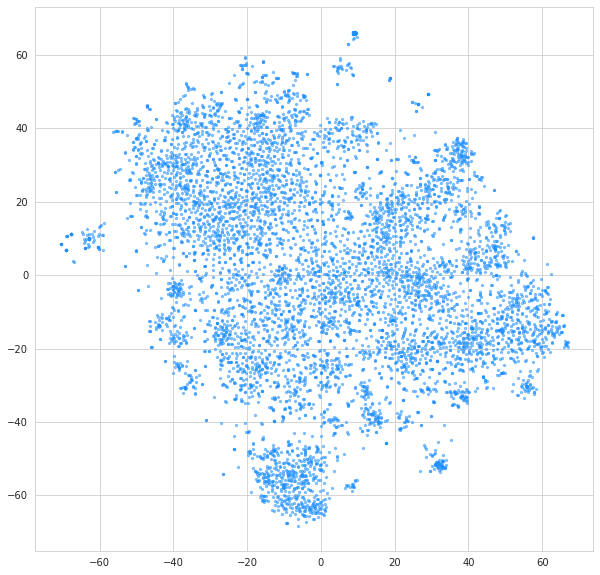

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(X_te_tsne[:, 0], X_te_tsne[:, 1], color='dodgerblue', alpha=0.5, s=5);

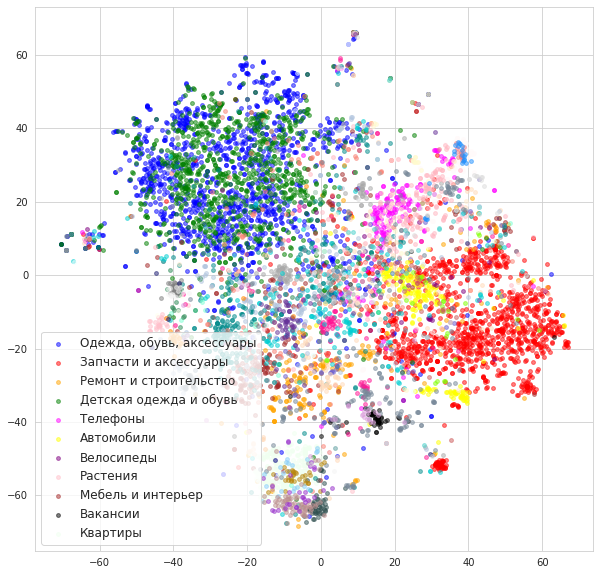

In [32]:
np.random.seed(42)
mpl_colors = np.random.permutation(list(matplotlib.colors.cnames.keys()))
mpl_colors = ['blue', 'red', 'orange', 'green', 'magenta', 'yellow', 'purple', 'pink', 'brown', 'black']
mpl_colors = np.array(mpl_colors + list(set(list(matplotlib.colors.cnames.keys())) - set(mpl_colors)))

plt.figure(figsize=(10, 10))
plt.title(f'Fasttext + t-SNE', fontsize=15)
for i, (category_id, category_name) in enumerate(categories_mapping.items()):
    plt.scatter(
        X_te_tsne[(test_df['Category'].values[tsne_idxs] == category_id), 0], 
        X_te_tsne[(test_df['Category'].values[tsne_idxs] == category_id), 1], color=mpl_colors[i], alpha=0.5, s=15,
        label=category_name if i <= 10 else ''
    );
plt.legend(fontsize=12);
    

In [34]:
%%time
from sklearn.linear_model import LogisticRegression

lr_fasttext = LogisticRegression(C=1.0, random_state=42)
lr_fasttext.fit(X_tr_emb, train_df['Category'].values)

CPU times: user 3min 36s, sys: 28.8 s, total: 4min 5s
Wall time: 2min 35s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [35]:
classification_report_fasttext_df = pd.DataFrame(classification_report(
    y_true=test_df['Category'].values,
    y_pred=lr_fasttext.predict(X_te_emb),
    target_names=[val for key, val in sorted(categories_mapping.items(), key=lambda x: x[0])],
    sample_weight=None,
    digits=2,
    output_dict=True,
    zero_division="warn",
)).T
classification_report_fasttext_df.style.background_gradient(axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Автомобили,0.780381,0.806049,0.793007,2645.000000
Запчасти и аксессуары,0.834675,0.922087,0.876206,15851.000000
Водный транспорт,0.731343,0.335616,0.460094,146.000000
Мотоциклы и мототехника,0.555556,0.158103,0.246154,253.000000
Ремонт и строительство,0.665091,0.703901,0.683946,2999.000000
Мебель и интерьер,0.684863,0.722603,0.703227,3212.000000
Бытовая техника,0.683248,0.608866,0.643916,1534.000000
Комнаты,0.891089,0.335821,0.487805,268.000000
Квартиры,0.871750,0.963513,0.915337,3097.000000
"Дома, дачи, коттеджи",0.806387,0.784466,0.795276,1030.000000


In [36]:
joined_report_df = pd.concat([
    classification_report_df.rename(
        columns={col: f"{col}_tfidf" for col in classification_report_df.columns}
    ),
    classification_report_fasttext_df.rename(
        columns={col: f"{col}_fasttext" for col in classification_report_fasttext_df.columns}
    ),
], axis=1)
for col in classification_report_df.columns:
    joined_report_df[f"{col.replace('_tfidf', '')}_diff"] = (
        joined_report_df[f"{col}_tfidf"] 
        - joined_report_df[f"{col}_fasttext"]
    )
joined_report_df[['precision_tfidf', 'recall_tfidf', 'support_tfidf', 'precision_diff', 'recall_diff', 'f1-score_diff']].style.background_gradient(
    axis=0, cmap='Reds'
)

,precision_tfidf,recall_tfidf,support_tfidf,precision_diff,recall_diff,f1-score_diff
Автомобили,0.873375,0.889225,2645.000000,0.092995,0.083176,0.088222
Запчасти и аксессуары,0.848778,0.941896,15851.000000,0.014102,0.019809,0.016709
Водный транспорт,0.855556,0.527397,146.000000,0.124212,0.191781,0.192448
Мотоциклы и мототехника,0.778571,0.430830,253.000000,0.223016,0.272727,0.308554
Ремонт и строительство,0.677140,0.704235,2999.000000,0.012049,0.000333,0.006475
Мебель и интерьер,0.716145,0.719489,3212.000000,0.031282,-0.003113,0.014587
Бытовая техника,0.629577,0.582790,1534.000000,-0.053671,-0.026076,-0.038635
Комнаты,0.883929,0.369403,268.000000,-0.007161,0.033582,0.033248
Квартиры,0.933563,0.961899,3097.000000,0.061813,-0.001614,0.032182
"Дома, дачи, коттеджи",0.859422,0.836893,1030.000000,0.053035,0.052427,0.052732


In [37]:
try:
    del X_tr_emb, X_te_emb
except:
    pass

gc.collect()

8663

<a id='RuBert'></a>
### RuBert
[к содержанию](#home)

In [10]:
!pip install -q transformers==4.23.1

     |████████████████████████        | 3.9 MB 5.1 MB/s eta 0:00:01

     |████████████████████████████████| 5.3 MB 5.1 MB/s 


     |████████████████████████████████| 163 kB 61.8 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 58.3 MB/s eta 0:00:01


In [11]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")
rubert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
%%time
np.random.seed(42)
N = 7_000
rubert_random_idxs = np.random.permutation(np.arange(len(test_df)))[:N]

X_te_rubert_emb = []
for descr in tqdm(test_df['description'].values[rubert_random_idxs]):
    try:
        inputs = tokenizer(descr, return_tensors='pt')
        outputs = rubert(**inputs)
        X_te_rubert_emb.append(
            outputs.last_hidden_state.mean(axis=1).squeeze().tolist()
        )
    except:
        X_te_rubert_emb.append([0]*len(X_te_rubert_emb[0]))
X_te_rubert_emb = np.array(X_te_rubert_emb)
print(f"X_te_rubert_emb: {X_te_rubert_emb.shape[0]:,} x {X_te_rubert_emb.shape[1]:,}")
try:
    np.save('/content/drive/MyDrive/tmp/X_te_rubert_emb_7k.npy', X_te_rubert_emb)
except:
    print(f"Не удалось сохранить X_te_rubert_emb_7k!")

  0%|          | 0/7000 [00:00<?, ?it/s]

X_te_rubert_emb: 7,000 x 768
CPU times: user 31min 20s, sys: 16.7 s, total: 31min 37s
Wall time: 31min 54s


In [24]:
X_te_rubert_emb = np.load('/content/drive/MyDrive/tmp/X_te_rubert_emb_7k.npy')
print(f"X_te_rubert_emb: {X_te_rubert_emb.shape[0]:,} x {X_te_rubert_emb.shape[1]:,}")

X_te_rubert_emb: 7,000 x 768


In [25]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_te_rubert_tsne = tsne.fit_transform(X_te_rubert_emb)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


CPU times: user 1min 50s, sys: 928 ms, total: 1min 50s
Wall time: 1min 3s


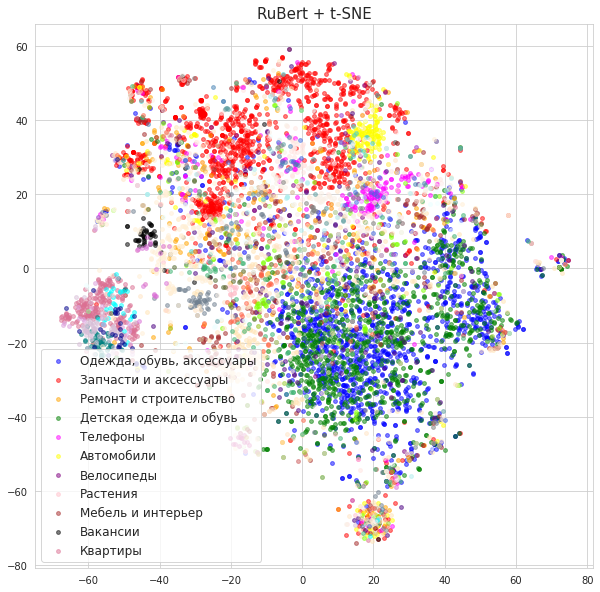

In [27]:
np.random.seed(42)
mpl_colors = np.random.permutation(list(matplotlib.colors.cnames.keys()))
mpl_colors = ['blue', 'red', 'orange', 'green', 'magenta', 'yellow', 'purple', 'pink', 'brown', 'black']
mpl_colors = np.array(mpl_colors + list(set(list(matplotlib.colors.cnames.keys())) - set(mpl_colors)))

plt.figure(figsize=(10, 10))
plt.title(f"RuBert + t-SNE", fontsize=15);
for i, (category_id, category_name) in enumerate(categories_mapping.items()):
    plt.scatter(
        X_te_rubert_tsne[(test_df['Category'].values[rubert_random_idxs] == category_id), 0], 
        X_te_rubert_tsne[(test_df['Category'].values[rubert_random_idxs] == category_id), 1], 
        color=mpl_colors[i], alpha=0.5, s=15,
        label=category_name if i <= 10 else ''
    );
plt.legend(fontsize=12);